In [ ]:
import pandas as pd
import requests
import yfinance as yf
from bs4 import BeautifulSoup
import re
import nltk
import numpy as np
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from scipy.stats import zscore
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm
import seaborn as sns

In [14]:
df = pd.read_csv('Data_PCLab3_Twitter_Stock_Sentiment.csv')

In [15]:
URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}  # avoid 403
html = requests.get(URL, headers=headers).text
soup = BeautifulSoup(html, "html.parser")
table = soup.find("table", {"id": "constituents"})
rows = table.find_all("tr")[1:]  

tickers = []
tickers_yf = []

for r in rows:
    cols = r.find_all("td")
    sym = cols[0].get_text(strip=True)
    name = cols[1].get_text(strip=True)

    tickers.append(sym)
    tickers_yf.append(sym.replace(".", "-"))

In [16]:
start = "2012-01-13"
end   = "2020-08-11"

yf_data = yf.download(tickers=tickers_yf, start=start, end=end)

/var/folders/n9/qk7dm0qj2p3893xpqm89nt_w0000gn/T/ipykernel_57980/870551532.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(tickers=tickers_yf, start=start, end=end)
[*********************100%***********************]  503 of 503 completed

13 Failed downloads:
['SOLV', 'CEG', 'HOOD', 'GEV', 'APP', 'VLTO', 'GEHC', 'PLTR', 'DASH', 'ABNB', 'KVUE', 'EXE', 'COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2012-01-13 -> 2020-08-11) (Yahoo error = "Data doesn\'t exist for startDate = 1326430800, endDate = 1597118400")')


In [17]:
close_prices = yf_data['Close'].copy()
close_prices

# Normalizing the prices
def normalize_price(df):  
    for stock in df.iloc[:, 1:]:
        df[stock] = df[stock]/df[stock][0]

# Applying the function
normalize_price(close_prices)

# Calculating daily returns
returns = close_prices.pct_change().iloc[1:]
returns = returns.reset_index()

/var/folders/n9/qk7dm0qj2p3893xpqm89nt_w0000gn/T/ipykernel_57980/500010618.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[stock] = df[stock]/df[stock][0]
/var/folders/n9/qk7dm0qj2p3893xpqm89nt_w0000gn/T/ipykernel_57980/500010618.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().iloc[1:]


# Task 1

In [18]:
# Number of tweets
num_tweets = len(df)
print(f"Number of tweets: {num_tweets}")

# Average number of words per sentiment class
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split()))
avg_by_sentiment = df.groupby('Sentiment')['word_count'].mean()
overall_avg = df['word_count'].mean()
pos = avg_by_sentiment.get(1, 0)
neg = avg_by_sentiment.get(0, 0)
print(f"Positive tweets average: {pos:.2f} words")
print(f"Negative tweets average: {neg:.2f} words")
print(f"Overall average: {overall_avg:.2f} words per tweet")

# Average sentiment
avg_sentiment = df['Sentiment'].mean()
print(f"Average sentiment: {avg_sentiment:.5f}")

Number of tweets: 5791
Positive tweets average: 13.98 words
Negative tweets average: 14.06 words
Overall average: 14.01 words per tweet
Average sentiment: 0.63633


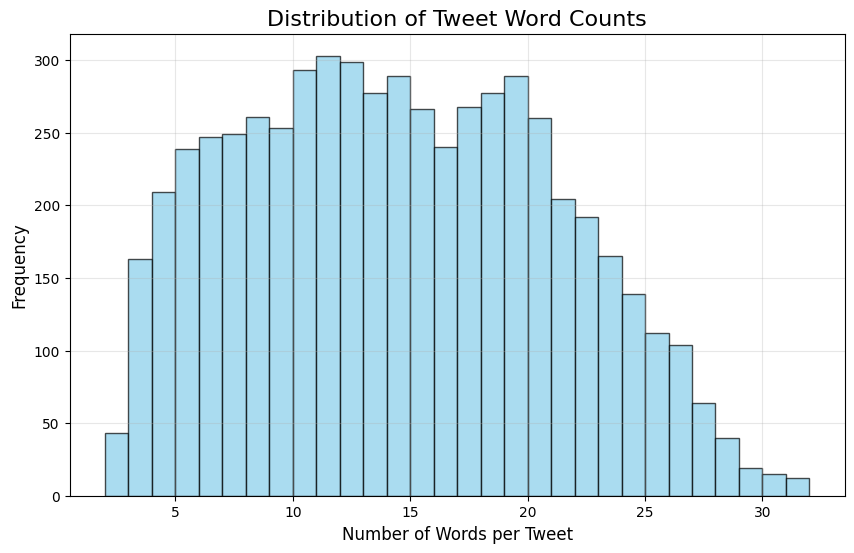

In [19]:
def plot_tweet_length_distribution(df, text_col="Text", bins=30):
    word_counts = df[text_col].fillna("").apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title("Distribution of Tweet Word Counts", fontsize=16)
    plt.xlabel("Number of Words per Tweet", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

plot_tweet_length_distribution(df, text_col="Text", bins=30)

# Task 2

### Text cleaning

In [20]:
for pkg in ["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"]:
    try:
        nltk.data.find(f"corpora/{pkg}" if pkg != "averaged_perceptron_tagger" else f"taggers/{pkg}")
    except LookupError:
        nltk.download(pkg, quiet=True)

_text_processor = TextPreProcessor(
    normalize=['url','email','percent','money','phone','user','time','date','number'],
    annotate={"hashtag", "allcaps", "elongated", "repeated"},
    all_caps_tag="allcaps",
    fix_html=True,
    segmenter="twitter",          # word segmenter for hashtags
    corrector="twitter",          # spell-correct social text
    unpack_hashtags=True,         # #TheBestDay -> the best day
    unpack_contractions=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]             # normalize emoticons
)

# Regex to remove (most) unicode emojis/symbols outside BMP
_EMOJI_RE = re.compile(r"[\U00010000-\U0010FFFF]", flags=re.UNICODE)

# Map POS tags to WordNet for lemmatization
_WN_MAP = {
    "J": wordnet.ADJ,
    "V": wordnet.VERB,
    "N": wordnet.NOUN,
    "R": wordnet.ADV
}

_STOPWORDS = set(stopwords.words("english")) | {
    "rt", "via", "amp"  # common twitter noise
}

_LEMMATIZER = WordNetLemmatizer()

def _lemmatize_tokens(tokens):
    tagged = pos_tag(tokens)
    lemmas = []
    for tok, tag in tagged:
        wn_pos = _WN_MAP.get(tag[0], wordnet.NOUN)
        lemmas.append(_LEMMATIZER.lemmatize(tok, wn_pos))
    return lemmas

def _clean_tweet_to_tokens(text: str):
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    # remove raw unicode emojis (ekphrasis handles emoticons like :), :D etc.)
    text = _EMOJI_RE.sub(" ", text)
    # ekphrasis tokenize + normalize
    tokens = _text_processor.pre_process_doc(text)

    cleaned = []
    for tok in tokens:
        # drop ekphrasis placeholders like <url>, <user>, <number>, <repeated>, <elongated>, <hashtag> etc.
        if tok.startswith("<") and tok.endswith(">"):
            continue
        # strip leading '#' left over (should be handled by unpack_hashtags, but just in case)
        if tok.startswith("#"):
            tok = tok[1:]
        # keep only alphabetic (drop punctuation, numbers)
        if not tok.isalpha():
            continue
        # stopwords
        if tok in _STOPWORDS:
            continue
        cleaned.append(tok)

    # lemmatize
    cleaned = _lemmatize_tokens(cleaned)
    # remove any stopwords that re-appear after lemmatization
    cleaned = [t for t in cleaned if t not in _STOPWORDS and len(t) > 1]
    return cleaned

def _tokens_to_corpus(tokens_series: pd.Series) -> str:
    # flatten list-of-tokens -> single space-joined string
    return " ".join(tok for tokens in tokens_series for tok in tokens)

df['Text'] = df['Text'].str.replace(r'\buser\b', '', case=False, regex=True).str.strip()

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


### Word cloud

In [21]:
def _trunc_cmap(name: str, vmin: float = 0.35, vmax: float = 1.0, n: int = 256):
    base = plt.cm.get_cmap(name, n)
    new_colors = base(np.linspace(vmin, vmax, n))
    return ListedColormap(new_colors)

def plot_sentiment_wordclouds(
    df: pd.DataFrame,
    text_col: str = "Text",
    label_col: str = "Sentiment",
    max_words: int = 300,
    width: int = 1000,
    height: int = 600,
    background_color: str = "white",
    pos_cmap: str = "Greens",
    neg_cmap: str = "Reds",
    cmap_min: float = 0.35,   # raise this for darker words
    cmap_max: float = 1.0
):
    if text_col not in df.columns or label_col not in df.columns:
        raise ValueError(f"Expected columns '{text_col}' and '{label_col}' in df")

    tokens = df[text_col].apply(_clean_tweet_to_tokens)
    pos_tokens = tokens[df[label_col] == 1]
    neg_tokens = tokens[df[label_col] == 0]

    pos_corpus = _tokens_to_corpus(pos_tokens)
    neg_corpus = _tokens_to_corpus(neg_tokens)

    wc_kwargs = dict(width=width, height=height, max_words=max_words, background_color=background_color)

    pos_wc = WordCloud(colormap=_trunc_cmap(pos_cmap, cmap_min, cmap_max), **wc_kwargs)\
                .generate(pos_corpus if pos_corpus.strip() else "positive")
    neg_wc = WordCloud(colormap=_trunc_cmap(neg_cmap, cmap_min, cmap_max), **wc_kwargs)\
                .generate(neg_corpus if neg_corpus.strip() else "negative")

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1); plt.imshow(pos_wc, interpolation="bilinear"); plt.title("Positive Sentiment", fontsize=18); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(neg_wc, interpolation="bilinear"); plt.title("Negative Sentiment", fontsize=18); plt.axis("off")
    plt.tight_layout(); plt.show()

/var/folders/n9/qk7dm0qj2p3893xpqm89nt_w0000gn/T/ipykernel_57980/408657074.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(name, n)


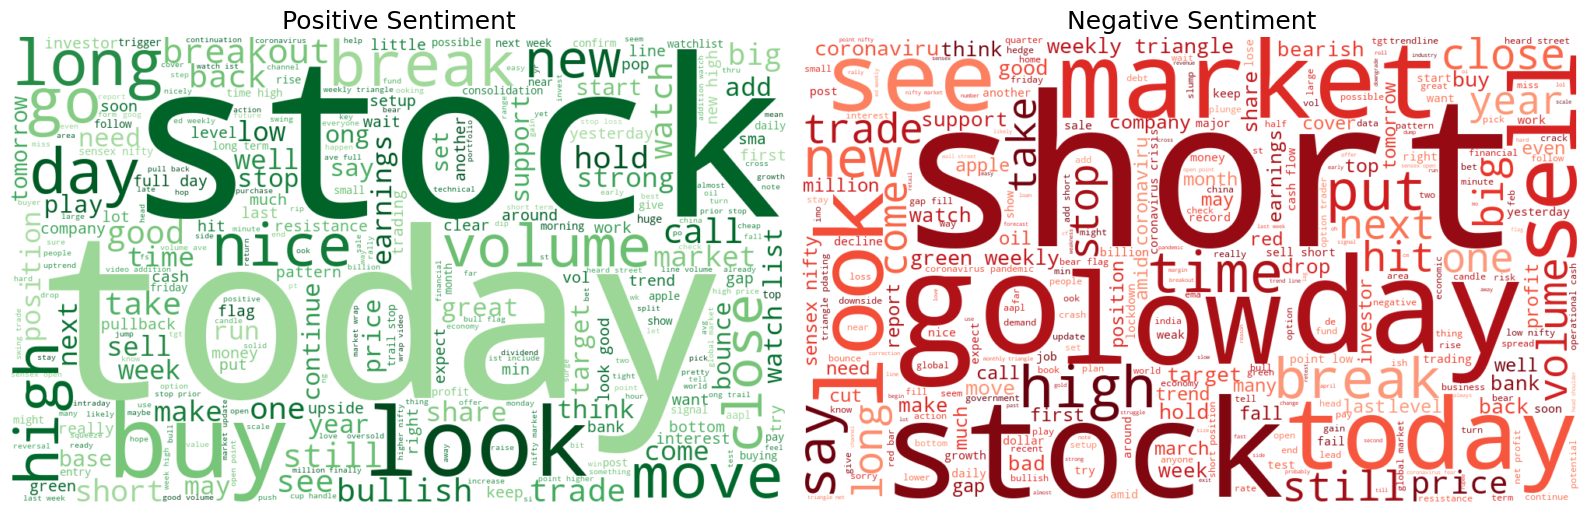

In [22]:
plot_sentiment_wordclouds(df, text_col="Text", label_col="Sentiment")

#### Unique words

In [23]:
# Total unique words
tokens = df["Text"].apply(_clean_tweet_to_tokens)

# Flatten all tokens into one list
all_words = [word for token_list in tokens for word in token_list]

# Unique word count
unique_word_count = len(set(all_words))
print(f"Total unique words: {unique_word_count}")

Total unique words: 5701


# Task 3

#### Twitter-RoBERTa

In [ ]:
# Load Twitter-RoBERTa
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def roberta_sentiment(texts, batch_size=32):
    results = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size].tolist()
        enc = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**enc)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        results.extend(preds)
    return results


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a 

In [25]:
df["roberta_sentiment"] = roberta_sentiment(df["Text"])

100%|██████████| 181/181 [00:59<00:00,  3.05it/s]


In [26]:
# Simplify 3-class into binary
df["roberta_binary"] = df["roberta_sentiment"].map({0: 0, 1: 0, 2: 1})
misclassification = (df["roberta_binary"] != df["Sentiment"]).mean()
print(f"Misclassification rate: {misclassification:.2%}")

Misclassification rate: 45.45%


In [27]:
df["roberta_binary"] = df["roberta_sentiment"].map({0: 0, 1: 1, 2: 1})
misclassification = (df["roberta_binary"] != df["Sentiment"]).mean()
print(f"Misclassification rate: {misclassification:.2%}")

Misclassification rate: 30.41%


To produce our own sentiment analysis, we decided to use Twitter-RoBERTa. The Model classifies text as expressing negative, neutral or positive sentiment. To compare the results of the model and the labeled tweets we needed to recode the sentiment outputs. We implemented two categorizations to test whether neutral sentiment is classified more often as positive or negeative setiment in the labeled dataset. 
* In the first case we recoded the outputs as {0: 0, 1: 0, 2: 1}, that is,  neutral is set to zero (negative sentiment) and obtained the misclassification rate of 45.45%.
* In the second case we recoded the outputs as {0: 0, 1: 1, 2: 1}, that is,  neutral is set to one (positive sentiment) and obtained the misclassification rate of 30.41%.  

We conclude that in the original labeled data, neutral sentiment is more often classified as positive sentiment. The reasons may be intepreted in the following way. If a stock has consistent performance, there is no cause for alarm nor reason to get excited about it, hence it is not a negative development. 

#### FinBERT

In [28]:
MODEL = "yiyanghkust/finbert-tone"  # or "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.eval()

id2label = model.config.id2label
label2id = {v.lower(): k for k, v in id2label.items()}  # {'negative':0,'neutral':1,'positive':2} typically

def finbert_sentiment(texts, batch_size=32, max_length=128):
    pred_ids, pred_labels, probs_all = [], [], []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts.iloc[i:i+batch_size].astype(str).tolist()  # keep original tweet text
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        with torch.no_grad():
            out = model(**enc)
        probs = torch.softmax(out.logits, dim=-1).cpu().numpy()   # shape (B,3)
        ids = probs.argmax(axis=1)

        pred_ids.extend(ids.tolist())
        pred_labels.extend([id2label[int(j)] for j in ids])
        probs_all.append(probs)

    probs_all = np.vstack(probs_all)  # shape (N,3)
    return np.array(pred_ids), np.array(pred_labels), probs_all

# ---- Run FinBERT
fin_ids, fin_labels, fin_probs = finbert_sentiment(df["Text"])

# Add columns safely
df["finbert_id"] = fin_ids
df["finbert_label"] = fin_labels

# Expand probs into 3 separate columns
prob_df = pd.DataFrame(fin_probs, columns=["finbert_prob_neg","finbert_prob_neu","finbert_prob_pos"], index=df.index)
df = pd.concat([df, prob_df], axis=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 181/181 [00:58<00:00,  3.12it/s]


In [29]:
map_to_binary = {
    label2id.get("negative", 0): 0,
    label2id.get("neutral", 1): 0,
    label2id.get("positive", 2): 1
}
df["finbert_binary"] = df["finbert_id"].map(map_to_binary)

misclassification_fb = (df["finbert_binary"] != df["Sentiment"]).mean()
print(f"Misclassification rate: {misclassification_fb:.2%}")

Misclassification rate: 48.14%


In [30]:
map_to_binary = {
    label2id.get("negative", 0): 0,
    label2id.get("neutral", 1): 1,
    label2id.get("positive", 2): 1
}
df["finbert_binary"] = df["finbert_id"].map(map_to_binary)

misclassification_fb = (df["finbert_binary"] != df["Sentiment"]).mean()
print(f"Misclassification rate: {misclassification_fb:.2%}")

Misclassification rate: 31.69%


We also implemented FinBERT and found the performance of the model to be worse then that of Twitter-RoBERTa. Nonetheless, we obtained similar results confirming our findings.

# Task 4

In task 4 we used the labeled dataset found by our classmates.

In [31]:
df2 = pd.read_csv('tweet_data.csv')

In [ ]:
# Create a dataframe with stock names and tweet counts
tweet_count_df = df2.groupby('symbol').size().reset_index(name='tweet_count')
tweet_count_df.columns = ['symbol', 'tweet_count']
tweet_count = tweet_count_df.drop([0, 15, 16, 17, 18, 30]).reset_index(drop=True)

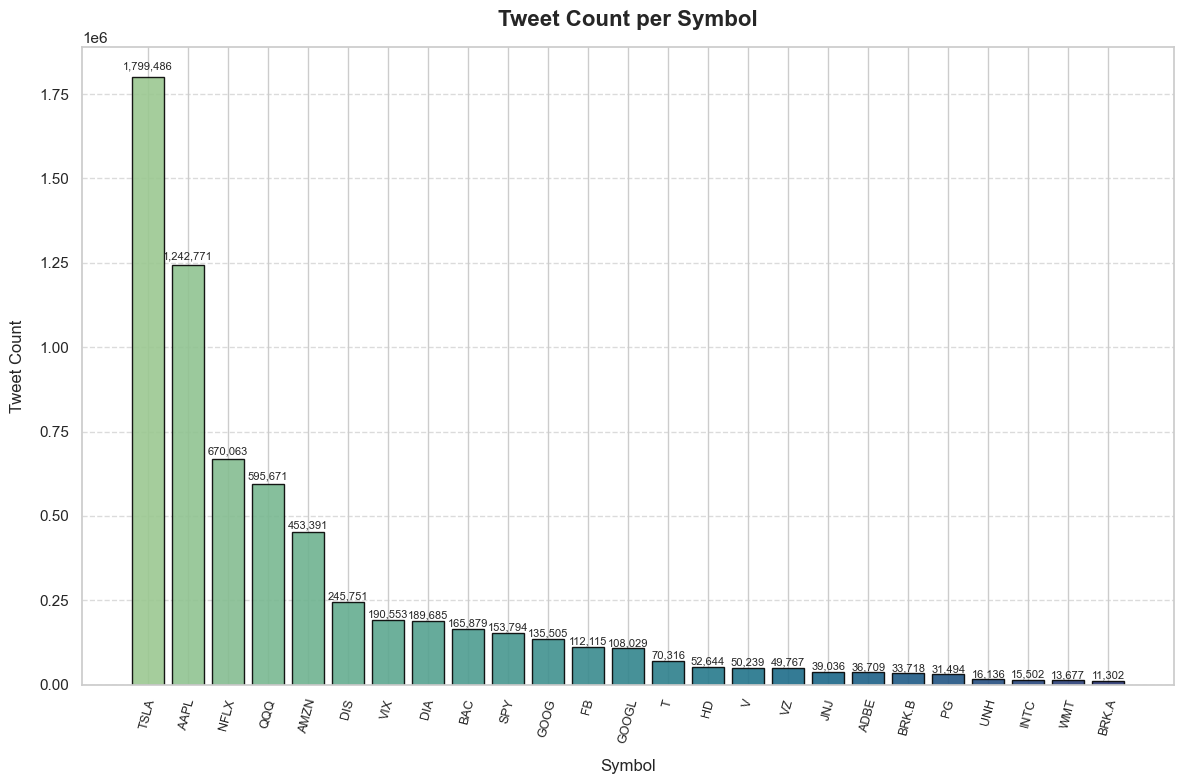

In [57]:
sns.set_theme(style="whitegrid")

# Sort by tweet count for better readability
tweet_count_sorted = tweet_count.sort_values(by='tweet_count', ascending=False)

# Create the plot
plt.figure(figsize=(12,8))
bars = plt.bar(
    tweet_count_sorted['symbol'],
    tweet_count_sorted['tweet_count'],
    color=sns.color_palette("crest", len(tweet_count_sorted)),
    edgecolor='black',
    alpha=0.9
)

# Add value labels on top of bars (optional)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + height * 0.01,  
        f'{int(height):,}',
        ha='center', va='bottom',
        fontsize=8, rotation=0
    )

# Customize axes and title
plt.xticks(rotation=75, fontsize=9)
plt.xlabel('Symbol', fontsize=12, labelpad=10)
plt.ylabel('Tweet Count', fontsize=12, labelpad=10)
plt.title('Tweet Count per Symbol', fontsize=16, fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Due to the large size of the dataset, we decided to downsize it and sample 70 tweets per symbol.

In [34]:
# Create a smaller dataset: sample 70 tweets per symbol from df2

# Ensure 'symbol' and 'message_id' columns exist and are not null/empty
df2_filtered = df2[df2['symbol'].notnull() & df2['message_id'].notnull() & (df2['message_id'] != '')]

# Sample up to 70 tweets per symbol
sampled_df2 = df2_filtered.groupby('symbol').apply(lambda x: x.sample(n=min(70, len(x)), random_state=42)).reset_index(drop=True)

/var/folders/n9/qk7dm0qj2p3893xpqm89nt_w0000gn/T/ipykernel_57980/1919607411.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df2 = df2_filtered.groupby('symbol').apply(lambda x: x.sample(n=min(70, len(x)), random_state=42)).reset_index(drop=True)


We repeated sentiment analysis on the new dataset, and again found that Twitter-RoBERTa performs better.

In [35]:
# Perform sentiment analysis on sampled_df2 using Twitter-RoBERTa
# Load Twitter-RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

labels = ['negative', 'neutral', 'positive']

def roberta_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment = np.argmax(probs.numpy())
        return labels[sentiment]

# Apply to the 'message' column
sampled_df2['roberta_sentiment'] = sampled_df2['message'].apply(roberta_sentiment)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a 

In [36]:
# Perform sentiment analysis on sampled_df2 using FinBERT
# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

def finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment = np.argmax(probs.numpy())
        # 0: negative, 1: neutral, 2: positive
        return ["negative", "neutral", "positive"][sentiment]

# Apply to the 'message' column
sampled_df2['finbert_sentiment'] = sampled_df2['message'].apply(finbert_sentiment)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Create summaries for each symbol in sampled_df2 using roberta_sentiment
summary_roberta_df = sampled_df2.groupby('symbol').agg(
    num_tweets=('message_id', 'count'),
    avg_sentiment=('roberta_sentiment', lambda x: (x == 'positive').mean() - (x == 'negative').mean()),
    positive_pct=('roberta_sentiment', lambda x: (x == 'positive').mean()),
    neutral_pct=('roberta_sentiment', lambda x: (x == 'neutral').mean()),
    negative_pct=('roberta_sentiment', lambda x: (x == 'negative').mean())
).reset_index()

In [59]:
# Create summaries for each symbol in sampled_df2
summary_finbert_df = sampled_df2.groupby('symbol').agg(
    num_tweets=('message_id', 'count'),
    avg_sentiment=('finbert_sentiment', lambda x: (x == 'positive').mean() - (x == 'negative').mean()),
    positive_pct=('finbert_sentiment', lambda x: (x == 'positive').mean()),
    neutral_pct=('finbert_sentiment', lambda x: (x == 'neutral').mean()),
    negative_pct=('finbert_sentiment', lambda x: (x == 'negative').mean())
).reset_index()

We compared the sentiment distributions for summary_roberta_df and summary_finbert_df and noticed that the percentage of negative scores was way too high for FinBERT. Therefore, we decided to use RoBERTa as our final model. 

### Creating the Media Attention Score

To develop the Media Attention Score we consulted ChatGPT. The score combines three aspects: volume - how much a stock is being talked about, intensity - how emotional or less neutral the sentiment is, and disagreement - how mixed or polarized opinions are. 
* Volume is calculated as the logarithm of one plus the tweet count, making it less sensitive to extremely active stocks. 
* Intensity is the product of how non-neutral the tweets are and the absolute value of their average sentiment.
* Disagreement captures how balanced positive and negative sentiment are—higher when both exist simultaneously. If sample size data is available, these components are adjusted for reliability so that smaller-sample estimates are shrunk toward zero.

Each component is z-scored across all stocks to put them on the same scale (in standard deviations) before combining them. This ensures comparability and prevents tweet volume from dominating the measure. The final score is calculated as:

* media_attention=0.5z(V)+0.3z(I)+0.2z(D)

A score of 0 represents average attention, +1 about one standard deviation above average (high attention), and –1 one standard deviation below average (low attention). Positive values indicate above-average attention and negative values below-average. If the score were to be recomputed daily using cross-sectional z-scores, a “+1” today is comparable to a “+1” next week.

In [63]:
eps = 1e-9

# Volume (V)
V = np.log1p(tweet_count["tweet_count"])

# Intensity (I)
I = (1 - summary_roberta_df["neutral_pct"].clip(0,1)) * summary_roberta_df["avg_sentiment"].abs()

# Disagreement (D)
emotion_share = (summary_roberta_df["positive_pct"].clip(0,1) + summary_roberta_df["negative_pct"].clip(0,1))
balance = 1 - (summary_roberta_df["positive_pct"].clip(0,1) - summary_roberta_df["negative_pct"].clip(0,1)).abs() / np.maximum(emotion_share, eps)
D = emotion_share * balance  # disagreement/polarization

# Final score
Z = pd.DataFrame({"V": V, "I": I, "D": D}).apply(zscore, nan_policy="omit")
summary_roberta_df["media_attention"] = Z.values @ np.array([0.5, 0.3, 0.2])

### Constructing the portfolios

In [65]:
summary_roberta_df = summary_roberta_df.sort_values("media_attention")
summary_roberta_df['portfolio'] = pd.qcut(summary_roberta_df['media_attention'], 10, labels=False) + 1

In [66]:
summary_roberta_df['symbol'] = summary_roberta_df['symbol'].replace({
    'BRK.B': 'BRK-B',
    'BRK.A': 'BK'
})

In [67]:
summary_roberta_df

,symbol,num_tweets,avg_sentiment,positive_pct,neutral_pct,negative_pct,media_attention,portfolio
4,BK,70,0.085714,0.214286,0.657143,0.128571,-1.096144,1
24,WMT,70,0.185714,0.271429,0.642857,0.085714,-0.931591,1
15,PG,70,0.114286,0.200000,0.714286,0.085714,-0.851204,1
23,VZ,70,0.242857,0.271429,0.700000,0.028571,-0.617772,2
20,UNH,70,0.185714,0.314286,0.557143,0.128571,-0.617585,2
12,INTC,70,0.185714,0.328571,0.528571,0.142857,-0.547485,3
18,T,70,-0.028571,0.171429,0.628571,0.200000,-0.407589,3
1,ADBE,70,0.171429,0.300000,0.571429,0.128571,-0.377078,3
5,BRK-B,70,0.200000,0.328571,0.542857,0.128571,-0.289275,4
17,SPY,70,-0.057143,0.128571,0.685714,0.185714,-0.223619,4


In [68]:
# Compute mean return of each stock
mean_returns = returns.mean()

# Merge with portfolio assignments
mean_returns_df = mean_returns.reset_index()
mean_returns_df.columns = ['symbol', 'mean_return']
merged_df = pd.merge(mean_returns_df, summary_roberta_df, on='symbol', how='inner')

# Compute average expected return per portfolio
expected_returns = merged_df.groupby('portfolio')['mean_return'].mean().sort_index()

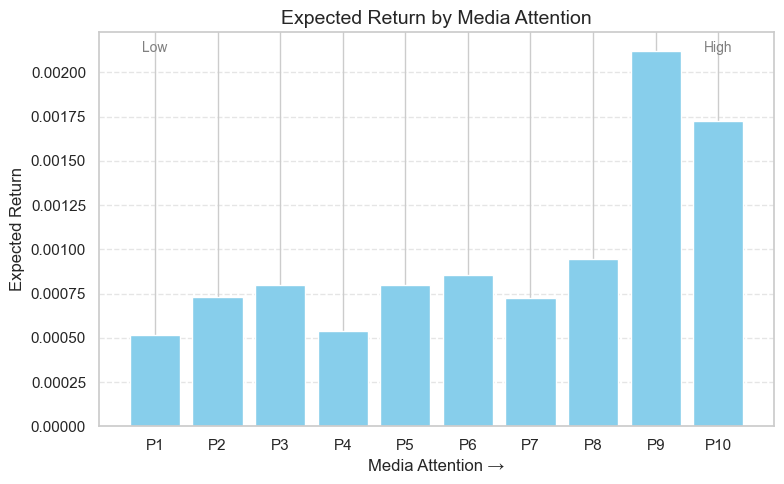

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute average media attention per portfolio (if not already)
media_attention = summary_roberta_df.groupby('portfolio')['media_attention'].mean()

# Combine both metrics
plot_df = pd.DataFrame({
    'Expected Return': expected_returns,
    'Media Attention': media_attention
})

# Sort by media attention (low → high)
plot_df = plot_df.sort_values('Media Attention')

# Plot in the same style as the sample image
plt.figure(figsize=(8,5))
plt.bar(plot_df.index, plot_df['Expected Return'], color='skyblue', width=0.8)

# Labels and styling
plt.xlabel('Media Attention →', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.title('Expected Return by Media Attention', fontsize=14)
plt.xticks(plot_df.index, [f'P{i}' for i in plot_df.index])  # optional
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Optional annotations for clarity
plt.text(plot_df.index[0], plt.ylim()[1]*0.95, 'Low', ha='center', fontsize=10, color='gray')
plt.text(plot_df.index[-1], plt.ylim()[1]*0.95, 'High', ha='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()


In [73]:
corr = plot_df['Media Attention'].corr(plot_df['Expected Return'])
print(f"Correlation between media attention and expected return: {corr:.4f}")

Correlation between media attention and expected return: 0.7666


As we can see from this preliminary result, the correlation between Media Attention and Expected Return is high. To further test the relationship between the two variables we decided to fit a simple linear model and check for the significance of the regressor's coefficient.

In [74]:
regr_df = plot_df

import statsmodels.api as sm

# Use plot_df from previous code (Media Attention, Expected Return)
X = regr_df['Media Attention']
y = pd.to_numeric(regr_df['Expected Return'], errors='coerce')

X_const = sm.add_constant(X)  # adds intercept
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Expected Return   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     11.40
Date:                Sun, 05 Oct 2025   Prob (F-statistic):            0.00969
Time:                        19:26:11   Log-Likelihood:                 66.291
No. Observations:                  10   AIC:                            -128.6
Df Residuals:                       8   BIC:                            -128.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0010      0.000     

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


From the summary statistics, we can see that the coefficent for Media Attention is significant at 5% thus confirming our previous findings. We can then conclude that there is a relationship between Media Attention and Expected Return. 

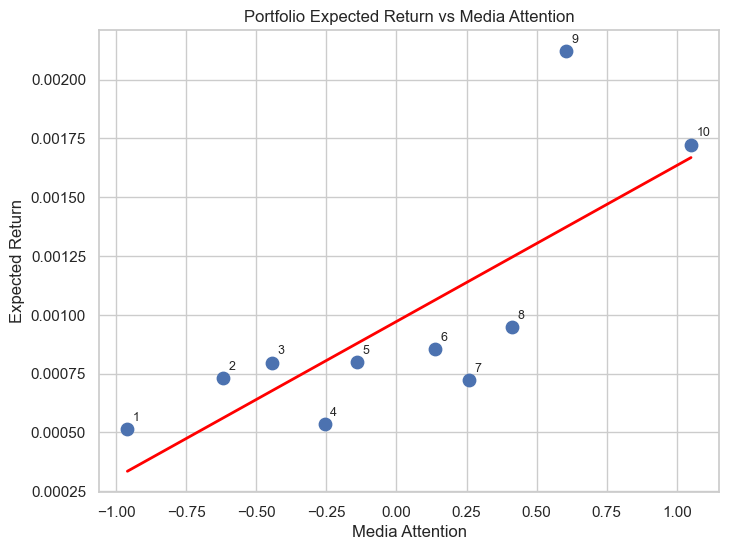

In [79]:
# If each portfolio has a unique media_attention value, we can take the mean per portfolio
media_attention = summary_roberta_df.groupby('portfolio')['media_attention'].mean()

# Combine with expected returns
plot_df = pd.DataFrame({
    'Expected Return': expected_returns,
    'Media Attention': media_attention
}).sort_index()

# Plot
plt.figure(figsize=(8,6))
plt.scatter(plot_df['Media Attention'], plot_df['Expected Return'], s=80)
plt.xlabel('Media Attention')
plt.ylabel('Expected Return')
plt.title('Portfolio Expected Return vs Media Attention')

# Regression line
import numpy as np
x = plot_df['Media Attention']
y = pd.to_numeric(plot_df['Expected Return'], errors='coerce')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linewidth=2, label='Regression Line')

# Label points
for i, row in plot_df.iterrows():
    plt.annotate(
        str(i),
        xy=(row['Media Attention'], row['Expected Return']),
        xytext=(4, 4),  
        textcoords='offset points',
        fontsize=9,
        ha='left', va='bottom'
    )

plt.grid(True)
plt.show()

### Final comments

We found that our Media Attention Score is significantly correlated with expected returns and remains statistically significant in a linear regression. This indicates that stocks receiving higher levels of Twitter attention tend to be associated with higher (or lower) expected returns depending on the direction of the relationship. The result suggests that social media activity reflects information or sentiment that aligns with investors’ expectations about future performance. Based on this we may not definitely conclude that Twitter attention helps predict returns, only that there is a significant relationship between them. 